In [2]:
from __future__ import print_function, division, unicode_literals

import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple of utility functions to plot grayscale 28x28 images

In [3]:
def plot_image(image, shape=[28,28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")
    return

def plot_multiple_images(images, n_rows, n_cols, pad=2):
    images = images - images.min() # make the minimum == 0, so the padding looks white
    w, h = images.shape[1:]
    image = np.zeros(((w+pad) * n_rows + pad,
                     (h+pad) * n_cols + pad))
    for y in range(n_rows):
        for x in range(n_cols):
            image[(y*(h+pad)+pad):(y*(h+pad)+pad+h),
                  (x*(w+pad)+pad):(x*(w+pad)+pad+w)] = images[y*n_cols+x]
    plt.imshow(image, cmap="Greys", interpolation="nearest")
    plt.axis("off")
    return

Autoencoders can do many things:
* they learn efficient representations of the input, known as coding, without any supervision
* codings can have dimensionality less than the input, thus they achieve Dimensionality Reduction
* they can act as powerful feature detectors
* they are capable of randomly generating new data that is very similar to the training data, thus they can act as a generative model

Task performed by Autoencoder is not trivial:
* can limit the size of internal representation
* can add noise to the input and train the network to recover the original inputs

Constraints prevent the autoencoder to copy the input to the outpus.

Dimensionality of input and output is the same.

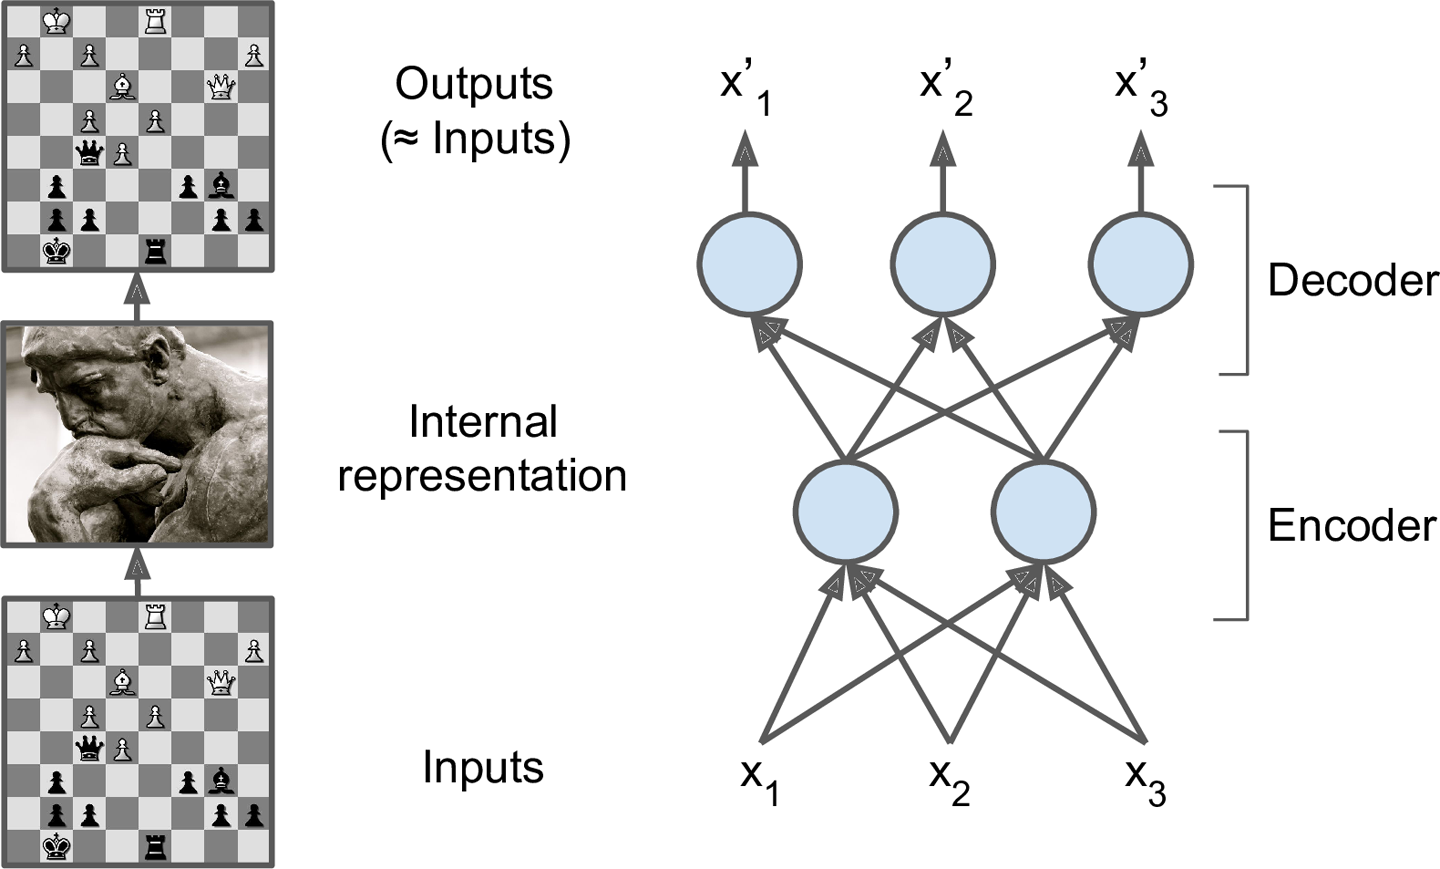

## PCA with a linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the Mean Squared Error (MSE), then it can be shown that it ends up performing Principal Component Analysis

Buil 3D dataset:

In [4]:
import numpy.random as rnd
rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

Preprocess data

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[:100])

In [6]:
import tensorflow as tf

In [7]:
reset_graph()

n_inputs = 3
n_hidden = 2 # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

In [9]:
n_iterations = 1000
codings = hidden

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
    codings_val = codings.eval(feed_dict={X: X_test})

Saving figure linear_autoencoder_pca_plot


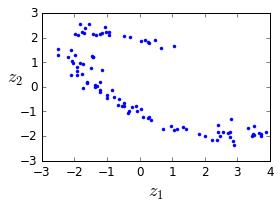

In [10]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings_val[:,0], codings_val[:,1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
save_fig("linear_autoencoder_pca_plot")
plt.show()

## Stacked Autoencoders

Provide layers to autoencoder hidden layer to learn more complex representations of the input data.

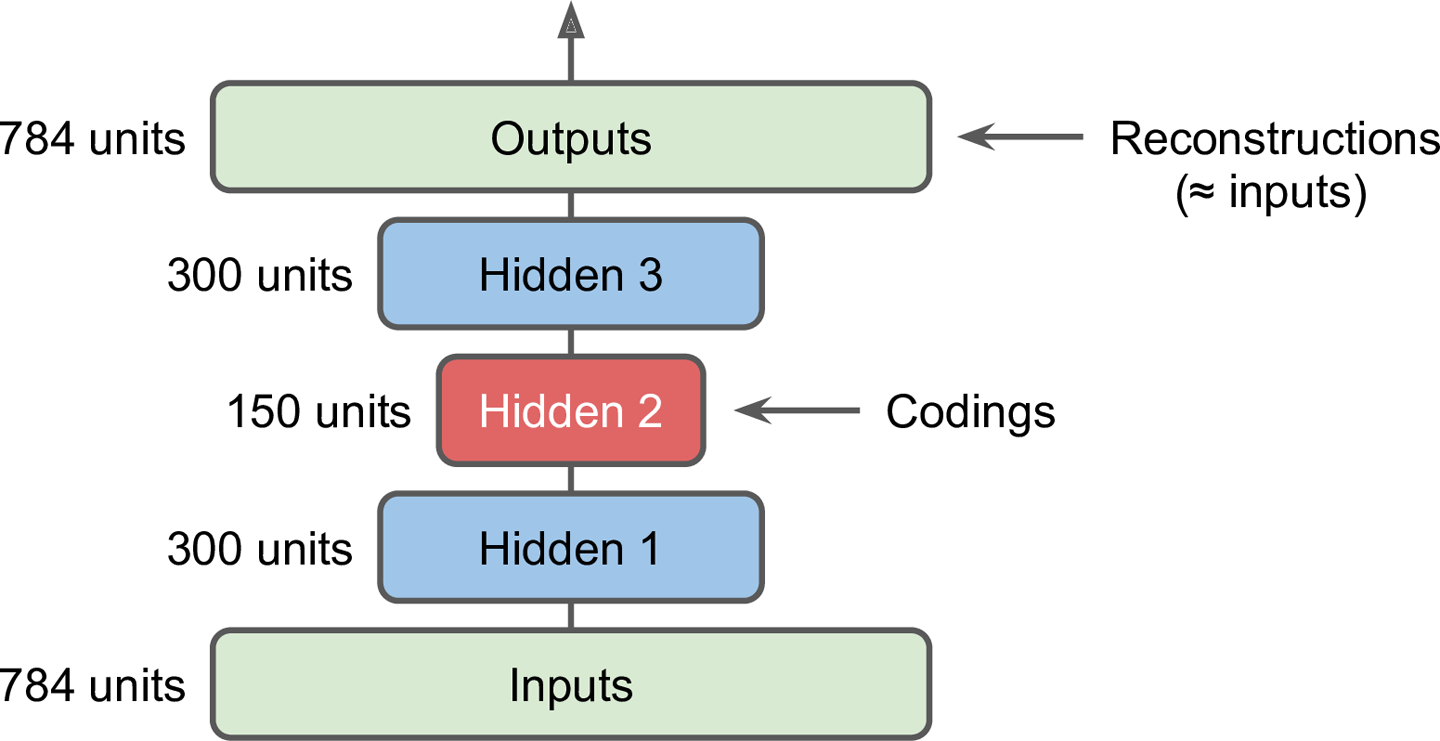

In [14]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./datasets/mnist1/")

Extracting ./datasets/mnist1/train-images-idx3-ubyte.gz
Extracting ./datasets/mnist1/train-labels-idx1-ubyte.gz
Extracting ./datasets/mnist1/t10k-images-idx3-ubyte.gz
Extracting ./datasets/mnist1/t10k-labels-idx1-ubyte.gz


Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (ie. 2 stacked Autoencoders). We will use ELU activation, He initialization and L2 regularization.

Note: since the `tf.layers.dense()` function is incompatible with `tf.contrib.layers.arg_scope()` (which is used in the book), we now use python's `functools.partial()` function instead. It makes it easy to create a `my_dense_layer()` function that just calls `tf.layers.dense()` with the desired parameters automatically set (unless they are overridden when calling `my_dense_layer()`).

In [12]:
reset_graph()

from functools import partial

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization

l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense, activation=tf.nn.elu,
                        kernel_initializer=he_init,
                        kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's train! Note that we don't feed target values (`y_batch` is not used). This is unsupervised training.

In [13]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_all_layers.ckpt")

09% Train MSE: 0.023305
19% Train MSE: 0.0115295
29% Train MSE: 0.0104114
39% Train MSE: 0.0101625
49% Train MSE: 0.00977806


This function loads the model, evaluates it on the test set (it measures the reconstruction error), then it displays the original image and its reconstruction:

In [7]:
def show_reconstructed_digits(X, outputs, model_path = None,
                             n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})
        
        fig = plt.figure(figsize=(8, 3 * n_test_digits))
        for digit_index in range(n_test_digits):
            plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
            plot_image(X_test[digit_index])
            plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
            plot_image(outputs_val[digit_index])

Saving figure reconstruction_plot


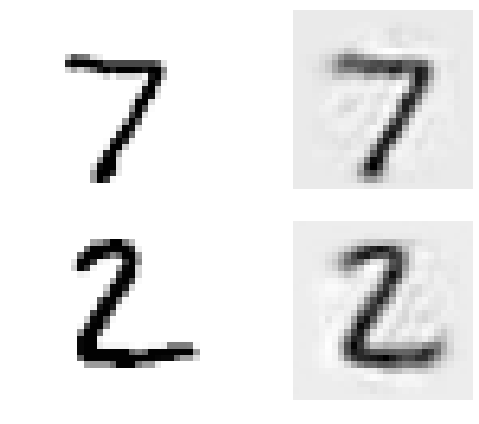

In [15]:
show_reconstructed_digits(X, outputs, "./my_model_all_layers.ckpt")
save_fig("reconstruction_plot")

## Tying Weights

When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers `(weights_decoder = tf.transpose(weights_encoder))`. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting.
Specifically, if the autoencoder has a total of $N$ layers (not counting the input layer), and $W_{l}$ represents the connection weights of the $L^{th}$ layer (e.g., layer 1 is the first hidden layer, layer  is the coding layer, and layer N is the output layer), then the decoder layer weights can be defined simply as: $W_{N–L+1} = W_{L}^{T}$ (with  L = 1, 2,$\ldots , \frac{N}{2}$).Unfortunately, implementing tied weights in TensorFlow using the `fully_connected()` function is a bit cumbersome; it’s actually easier to just define the layers manually.


In [16]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0005

In [20]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

wt1_init = initializer([n_inputs, n_hidden1])
wt2_init = initializer([n_hidden1, n_hidden2])

# wt3 and wt4 are NOT variables but transpose of wt2 and wt1 respectively
# thus they are tied
# wt3 and wt4 are NOT regularized (since they are not varaibles)
# biases are never tied nor regularized

wt1 = tf.Variable(wt1_init, dtype=tf.float32, name="weights1")
wt2 = tf.Variable(wt2_init, dtype=tf.float32, name="weights2")
wt3 = tf.transpose(wt2, name="weights3") # tied weights
wt4 = tf.transpose(wt1, name="weights4") # tied weights

b1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
b2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
b3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
b4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, wt1) + b1)
hidden2 = activation(tf.matmul(hidden1, wt2) + b2)
hidden3 = activation(tf.matmul(hidden2, wt3) + b3)
outputs = activation(tf.matmul(hidden3, wt4) + b4)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))
reg_loss = regularizer(wt1) + regularizer(wt2)
loss = reconstruction_loss + reg_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [21]:
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_tying_weights.ckpt")

0 Train MSE: 0.0165294
19% Train MSE: 0.0165421
29% Train MSE: 0.0165554
39% Train MSE: 0.0163054
4 Train MSE: 0.0169105


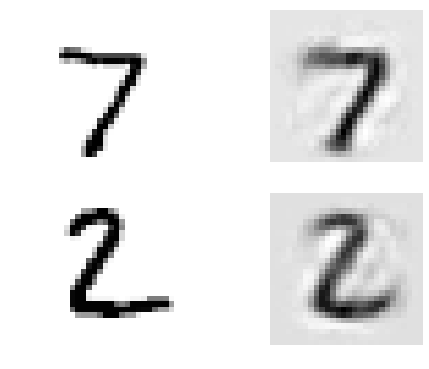

In [22]:
show_reconstructed_digits(X, outputs, "./my_model_tying_weights.ckpt")

## Training one Autoencoder at a time in <br/>multiple graphs

Its often more faster to train multiple shallow autoencoders and then stack them together to form a deep autoencoder.

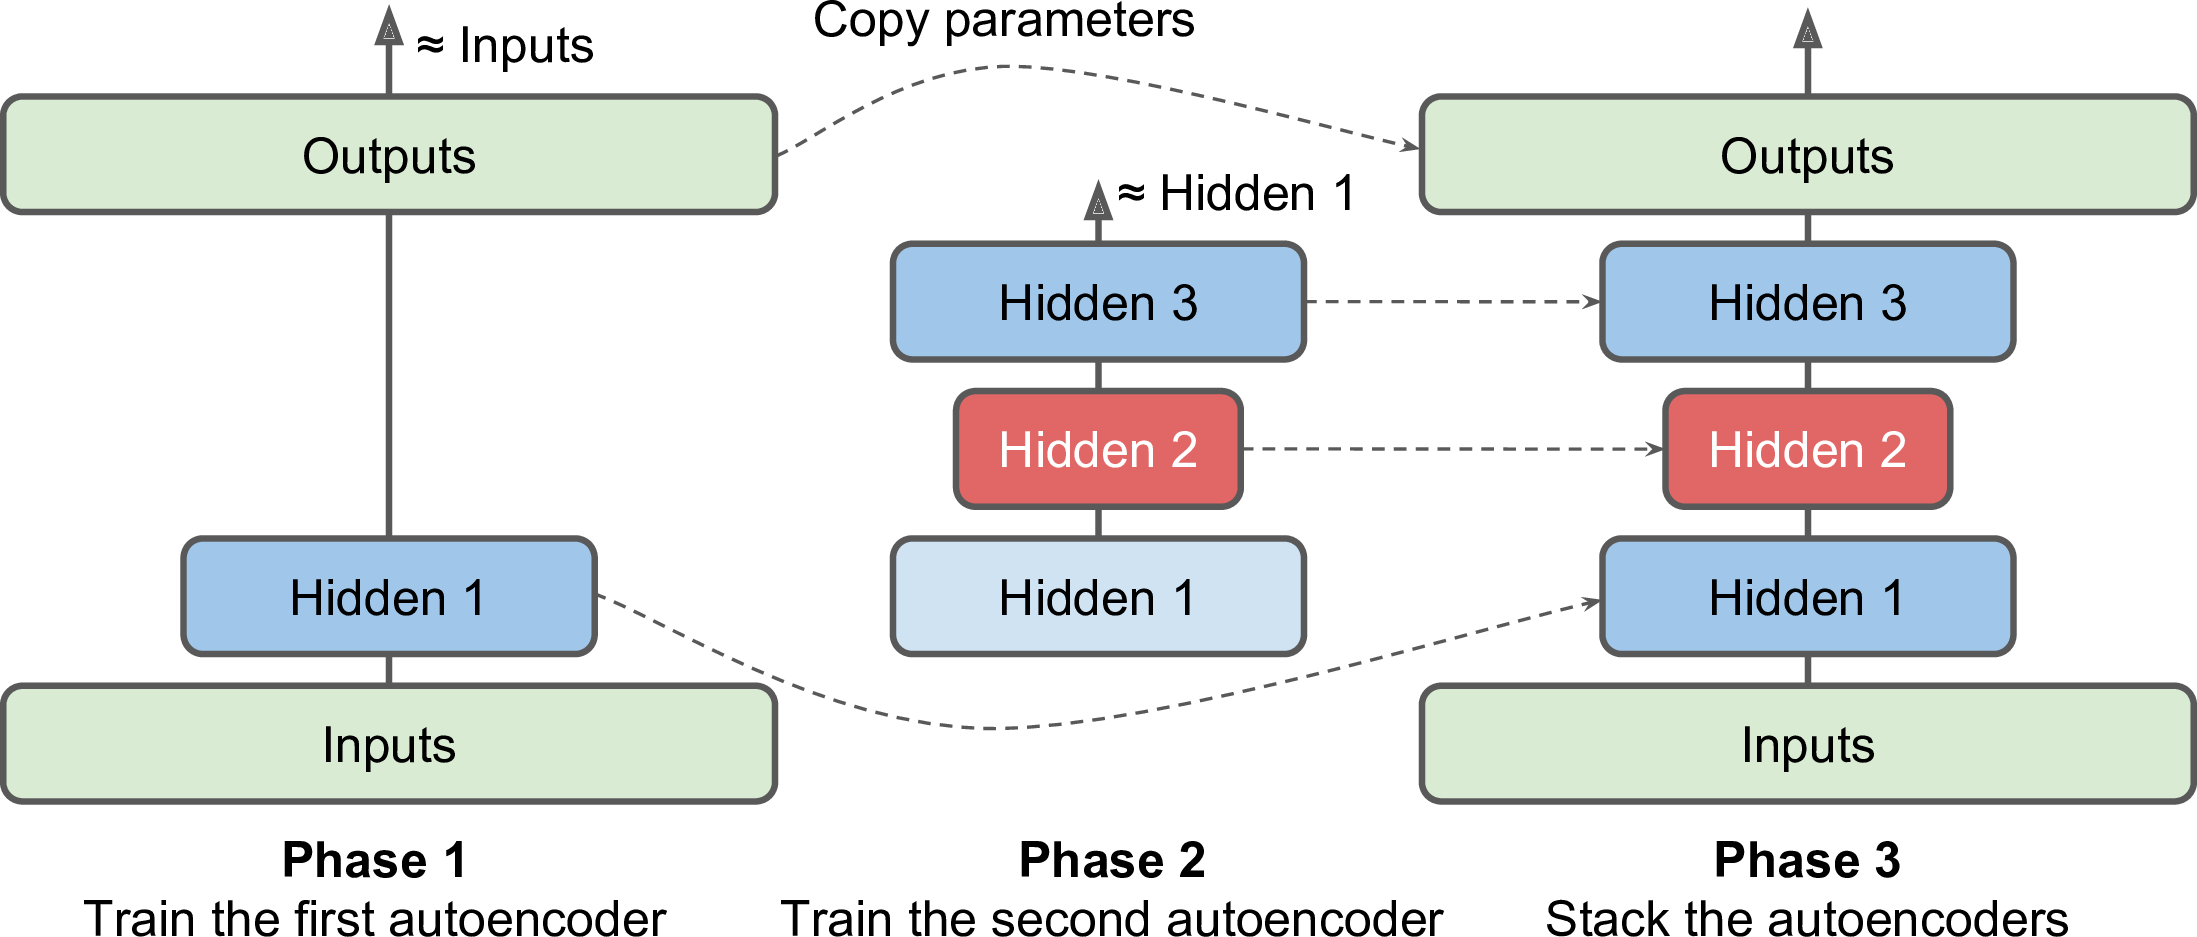

During the first phase of training, the first autoencoder learns to reconstruct the inputs. During the second phase, the second autoencoder learns to reconstruct the output of the first autoencoder’s hidden layer. Finally, you just build a big sandwich using all these autoencoders.<br/>

To implement this multiphase training algorithm, the simplest approach is to use a different TensorFlow graph for each phase. After training an autoencoder, you just run the training set through it and capture the output of the hidden layer. This output then serves as the training set for the next autoencoder. Once all autoencoders have been trained this way, you simply copy the weights and biases from each autoencoder and use them to build the stacked autoencoder.

Let's create a function that will train one autoencoder and return the transformed training set (i.e., the output of the hidden layer) and the model parameters.

In [28]:
reset_graph()

from functools import partial

def train_autoencoder(X_train, n_neurons, n_epochs, batch_size,
                      learning_rate = 0.01, l2_reg = 0.0005,
                      activation=tf.nn.elu, seed=42):
    graph = tf.Graph()
    with graph.as_default():
        tf.set_random_seed(seed)

        n_inputs = X_train.shape[1]

        X = tf.placeholder(tf.float32, shape=[None, n_inputs])
        
        # define a tf.layers.dense() with activation, initialization
        # and regularizer
        my_dense_layer = partial(
            tf.layers.dense,
            activation=activation,
            kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(l2_reg))

        hidden = my_dense_layer(X, n_neurons, name="hidden")
        outputs = my_dense_layer(hidden, n_inputs, activation=None, name="outputs")

        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

        reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = tf.add_n([reconstruction_loss] + reg_losses)

        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

        init = tf.global_variables_initializer()

    with tf.Session(graph=graph) as sess:
        init.run()
        for epoch in range(n_epochs):
            n_batches = len(X_train) // batch_size
            
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                # construct a batch from the input X_train
                indices = rnd.permutation(len(X_train))[:batch_size]
                X_batch = X_train[indices]
                sess.run(training_op, feed_dict={X: X_batch})
            
            loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
        
        params = dict([(var.name, var.eval()) for var in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)])
        hidden_val = hidden.eval(feed_dict={X: X_train})
        return hidden_val, params["hidden/kernel:0"], params["hidden/bias:0"], params["outputs/kernel:0"], params["outputs/bias:0"]

Now let's train two Autoencoders. The first one is trained on the training data, and the second is trained on the previous Autoencoder's hidden layer output:

In [29]:
hidden_output, W1, b1, W4, b4 = train_autoencoder(mnist.train.images, 
                                                  n_neurons=300, n_epochs=4, 
                                                  batch_size=150)
# output of the first autoencoder is given as input to the next autoencoder
_, W2, b2, W3, b3 = train_autoencoder(hidden_output, n_neurons=150, 
                                      n_epochs=4, batch_size=150)

09% Train MSE: 0.0186772
1 Train MSE: 0.0195928
29% Train MSE: 0.0185367
39% Train MSE: 0.0194414
0 Train MSE: 0.00433411
1 Train MSE: 0.00459767
29% Train MSE: 0.00436452
39% Train MSE: 0.00458709


Finally, we can create a Stacked Autoencoder by simply reusing the weights and biases from the Autoencoders we just trained:

In [30]:
reset_graph()

n_inputs = 28 * 28

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.nn.elu(tf.matmul(hidden3, W4) + b4)

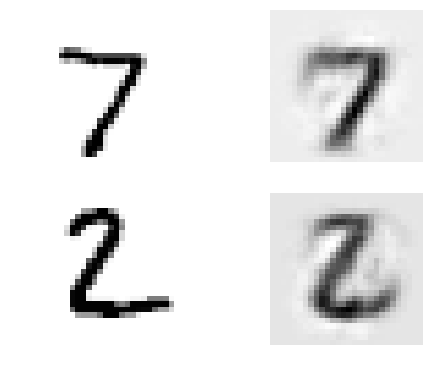

In [31]:
show_reconstructed_digits(X, outputs)

## Training one Autoencoder at a time in a <br/> single graph

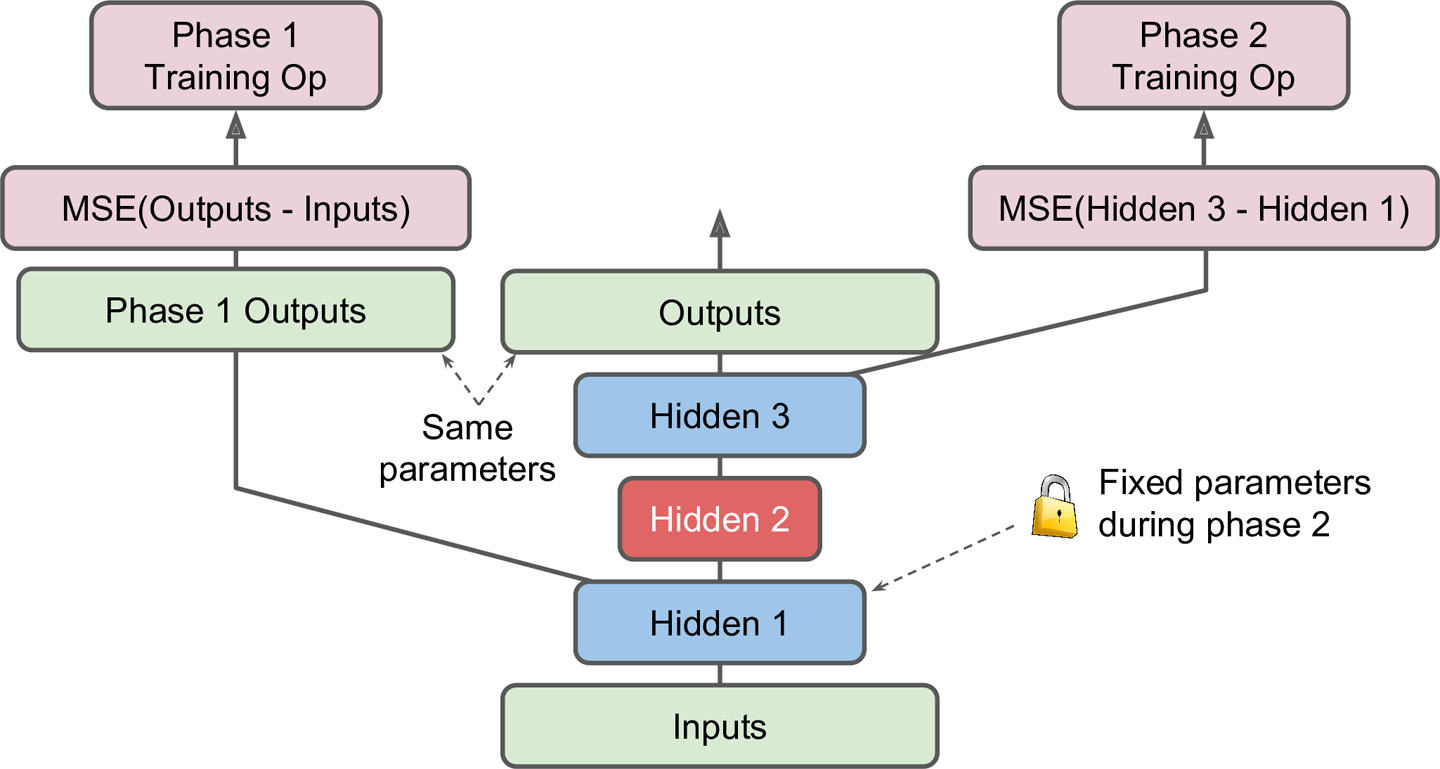

* The central column in the graph is the full stacked autoencoder. This part can be used after training.
* The left column is the set of operations needed to run the first phase of training. It creates an output layer that bypasses hidden layers 2 and 3. This output layer shares the same weights and biases as the stacked autoencoder’s output layer. On top of that are the training operations that will aim at making the output as close as possible to the inputs. Thus, this phase will train the weights and biases for the hidden layer 1 and the output layer (i.e., the first autoencoder).
* The right column in the graph is the set of operations needed to run the second phase of training. It adds the training operation that will aim at making the output of hidden layer 3 as close as possible to the output of hidden layer 1. Note that we must freeze hidden layer 1 while running phase 2. This phase will train the weights and biases for hidden layers 2 and 3 (i.e., the second autoencoder).



we create the graph for the full Stacked Autoencoder, but then we also add operations to train each Autoencoder independently: phase 1 trains the bottom and top layer (ie. the first Autoencoder) and phase 2 trains the two middle layers (ie. the second Autoencoder).

In [8]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

In [9]:
activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [13]:
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    # bypass hiddden 2 and hidden3 layers
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4
    
    # try to minimize reconstruction loss between the input and output
    # using hidden1 layer
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    
    # regularize the weights of each layer
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)
    
with tf.name_scope("phase2"):
    # weights of hidden1 layer are not changed
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    # freeze hidden1 layer
    phase2_training_op = optimizer.minimize(phase2_loss,
                                           var_list=train_vars)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

The first phase is rather straightforward: we just create an output layer that skips hidden layers 2 and 3, then build the training operations to minimize the distance between the outputs and the inputs (plus some regularization).<br/>

The second phase just adds the operations needed to minimize the distance between the output of hidden layer 3 and hidden layer 1 (also with some regularization). Most importantly, we provide the list of trainable variables to the minimize() method, making sure to leave out weights1 and biases1; this effectively freezes hidden layer 1 during phase 2.<br/>

During the execution phase, all you need to do is run the phase 1 training op for a number of epochs, then the phase 2 training op for some more epochs.

In [16]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, 
                         phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase+1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={
                X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.00716017
19% Train MSE: 0.00705999
29% Train MSE: 0.0074767
3 Train MSE: 0.00755667
Training phase #2
09% Train MSE: 0.338624
19% Train MSE: 0.00603434
29% Train MSE: 0.00300431
39% Train MSE: 0.00208403
Test MSE: 0.00972268


## Cache the frozen layer outputs

Since hidden layer 1 is frozen during phase 2, its output will always be the same for any given training instance. To avoid having to recompute the output of hidden layer 1 at every single epoch, you can compute it for the whole training set at the end of phase 1, then directly feed the cached output of hidden layer 1 during phase 2. This can give you a nice performance boost.

In [17]:
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        if phase == 1:
            hidden1_cache = hidden1.eval(feed_dict={X: mnist.train.images})
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                if phase == 1:
                    indices = rnd.permutation(mnist.train.num_examples)
                    hidden1_batch = hidden1_cache[indices[:batch_sizes[phase]]]
                    feed_dict = {hidden1: hidden1_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
                else:
                    X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                    feed_dict = {X: X_batch}
                    sess.run(training_ops[phase], feed_dict=feed_dict)
            loss_train = reconstruction_losses[phase].eval(feed_dict=feed_dict)
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_cache_frozen.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
09% Train MSE: 0.00739332
1 Train MSE: 0.00796862
29% Train MSE: 0.00750292
39% Train MSE: 0.00765816
Training phase #2
09% Train MSE: 0.0788391
1 Train MSE: 0.00474733
29% Train MSE: 0.00221939
39% Train MSE: 0.00196781
Test MSE: 0.00978415


## Visualizing the Reconstructions

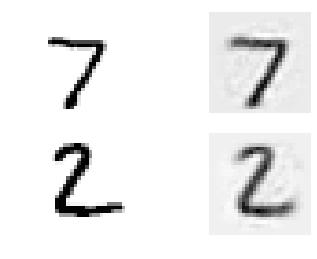

In [18]:
n_test_digits = 2
X_test = mnist.test.images[:n_test_digits]

with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt") # not shown in the book
    outputs_val = outputs.eval(feed_dict={X: X_test})

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

for digit_index in range(n_test_digits):
    plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
    plot_image(X_test[digit_index])
    plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
    plot_image(outputs_val[digit_index])

## visualizing the extracted features

Once your autoencoder has learned some features, you may want to take a look at them. There are various techniques for this. Arguably the simplest technique is to consider each neuron in every hidden layer, and find the training instances that activate it the most. This is especially useful for the top hidden layers since they often capture relatively large features that you can easily spot in a group of training instances that contain them. For example, if a neuron strongly activates when it sees a cat in a picture, it will be pretty obvious that the pictures that activate it the most all contain cats. However, for lower layers, this technique does not work so well, as the features are smaller and more abstract, so it’s often hard to understand exactly what the neuron is getting all excited about.<br/>

Let’s look at another technique. For each neuron in the first hidden layer, you can create an image where a pixel’s intensity corresponds to the weight of the connection to the given neuron. For example, the following code plots the features learned by five neurons in the first hidden layer:

Saving figure extracted_features_plot


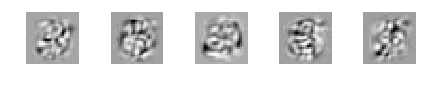

In [20]:
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()
    
for i in range(5):
    plt.subplot(1, 5, i+1)
    plot_image(weights1_val.T[i])
    
save_fig("extracted_features_plot")
plt.show()

Another technique is to feed the autoencoder a random input image, measure the activation of the neuron you are interested in, and then perform backpropagation to tweak the image in such a way that the neuron will activate even more. If you iterate several times (performing gradient ascent), the image will gradually turn into the most exciting image (for the neuron). This is a useful technique to visualize the kinds of inputs that a neuron is looking for.<br/>

Finally, if you are using an autoencoder to perform unsupervised pretraining—for example, for a classification task—a simple way to verify that the features learned by the autoencoder are useful is to measure the performance of the classifier.

## Unsupervised Pretraining using Stacked Autoencoders

If you are tackling a complex supervised task but you do not have a lot of labeled training data, one solution is to find a neural network that performs a similar task, and then reuse its lower layers. This makes it possible to train a high-performance model using only little training data because your neural network won’t have to learn all the low-level features; it will just reuse the feature detectors learned by the existing net.<br/>

Similarly, if you have a large dataset but most of it is unlabeled, you can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for your actual task, and train it using the labeled data. For example, Figure shows how to use a stacked autoencoder to perform unsupervised pretraining for a classification neural network. The stacked autoencoder itself is typically trained one autoencoder at a time. When training the classifier, if you really don’t have much labeled training data, you may want to freeze the pretrained layers (at least the lower ones).

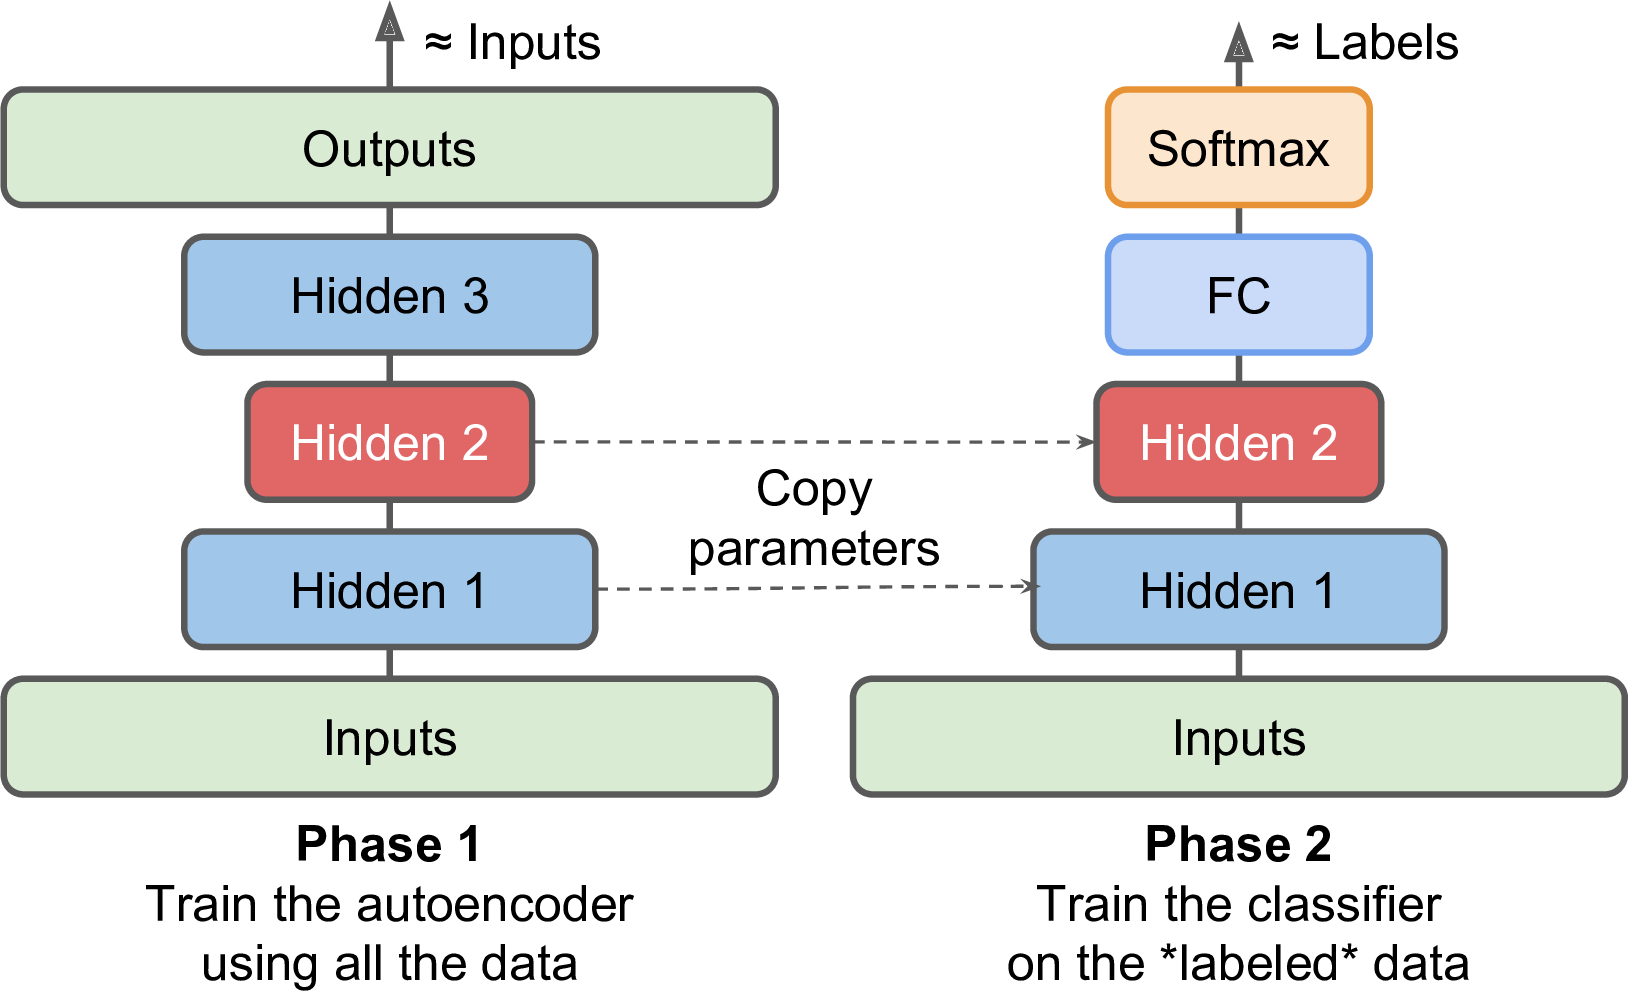

One of the triggers of the current Deep Learning tsunami is the discovery in 2006 by Geoffrey Hinton et al. that deep neural networks can be pretrained in an unsupervised fashion. They used restricted Boltzmann machines for that, but in 2007 Yoshua Bengio et al. showed that autoencoders worked just as well.

Let's create a small neural network for MNIST classification:

In [71]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150
n_outputs = 10

learning_rate = 0.01
l2_reg = 0.0005

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.int32, shape=[None])

In [72]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=activation,
                         kernel_initializer=initializer,
                         kernel_regularizer=regularizer, name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=activation,
                         kernel_initializer=initializer,
                         kernel_regularizer=regularizer, name="hidden2")
logits = tf.layers.dense(hidden2, n_outputs, activation=activation,
                         kernel_initializer=initializer,
                         kernel_regularizer=regularizer, name="hidden3")

In [73]:
var_name = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

In [74]:
print([var_name[i].name for i in range(len(var_name))])

['hidden1/kernel:0', 'hidden1/bias:0', 'hidden2/kernel:0', 'hidden2/bias:0', 'hidden3/kernel:0', 'hidden3/bias:0']


In [75]:
def get_tensor(tensor_name):
    return tf.get_default_graph().get_tensor_by_name(tensor_name)

In [76]:
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                              logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(cross_entropy)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
weights1 = get_tensor("hidden1/kernel:0")
weights2 = get_tensor("hidden2/kernel:0")
biases1 = get_tensor("hidden1/bias:0")
biases2 = get_tensor("hidden2/bias:0")
pretrain_saver = tf.train.Saver([weights1, weights2, biases1, biases2])
saver = tf.train.Saver()

Regular training (without pretraining):

In [77]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100*iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="")
        saver.save(sess, "./my_model_supervised.ckpt")
        pretrain_saver.save(sess, "./my_model_cache_frozen.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images,
                                               y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

0 %Train accuracy: 0.966667Test accuracy: 0.9539
1 Train accuracy: 0.913333Test accuracy: 0.9527
29% Train accuracy: 1.0Test accuracy: 0.9977
39% Train accuracy: 1.0Test accuracy: 0.9897


Now reusing the first two layers of the autoencoder we pretrained:

In [80]:
n_epochs = 4
batch_size = 150
n_labeled_instances = 20000

with tf.Session() as sess:
    init.run()
    pretrain_saver.restore(sess, "./my_model_cache_frozen.ckpt")
    for epoch in range(n_epochs):
        n_batches = n_labeled_instances // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100*iteration // n_batches), end="")
            sys.stdout.flush()
            indices = rnd.permutation(n_labeled_instances)[:batch_size]
            X_batch, y_batch = mnist.train.images[indices], mnist.train.labels[indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print("\r{}".format(epoch), "Train accuracy:", accuracy_val, end="\t")
        saver.save(sess, "./my_model_supervised_pretrained.ckpt")
        accuracy_val = accuracy.eval(feed_dict={X: mnist.test.images, y: mnist.test.labels})
        print("Test accuracy:", accuracy_val)

09% Train accuracy: 1.0	Test accuracy: 0.9977
1 Train accuracy: 1.0	Test accuracy: 0.9988
29% Train accuracy: 1.0	Test accuracy: 0.9991
39% Train accuracy: 1.0	Test accuracy: 0.9999


## Stacked Denoising Autoencoders

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to be just as large as the inputs, or even larger, resulting in an overcomplete autoencoder.<br/>

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This prevents the autoencoder from trivially copying its inputs to its outputs, so it ends up having to find patterns in the data.<br/>

The idea of using autoencoders to remove noise has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a 2008 paper,3 Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a 2010 paper,4 Vincent et al. introduced stacked denoising autoencoders.<br/>

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched off inputs, just like in dropout

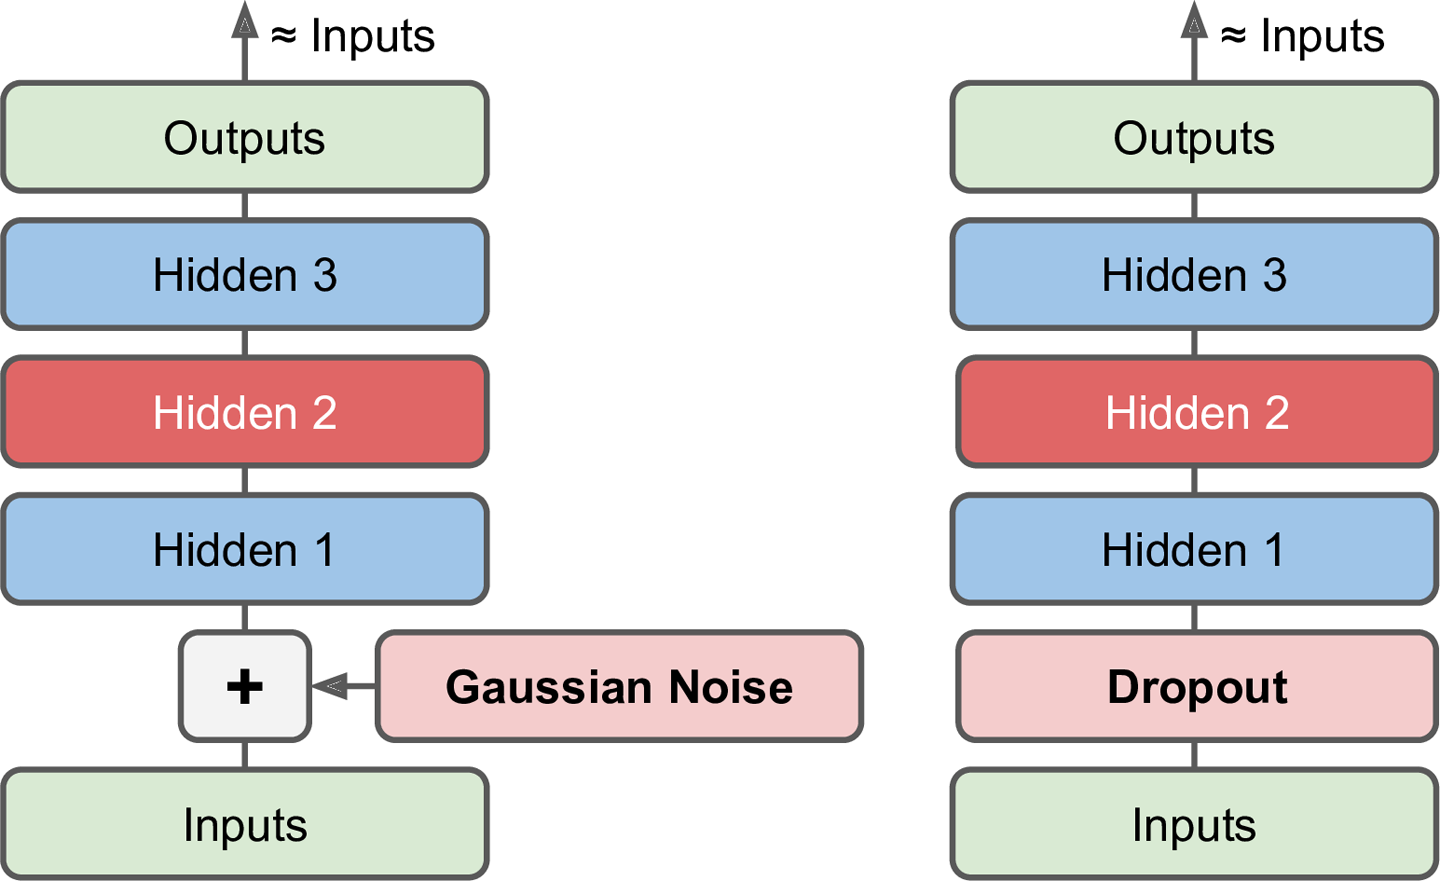

Implementing denoising autoencoders in TensorFlow is not too hard. Let’s start with Gaussian noise. It’s really just like training a regular autoencoder, except you add noise to the inputs, and the reconstruction loss is calculated based on the original inputs:

```python
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + tf.random_normal(tf.shape(X))
[...]
hidden1 = activation(tf.matmul(X_noisy, weights1) + biases1)
[...]
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))  # MSE
[...]
```

**Note:** Since the shape of `X` is only partially defined during the construction phase, we cannot know in advance the shape of the noise that we must add to `X`. We cannot call `X.get_shape()` because this would just return the partially defined shape of `X ([None, n_inputs])`, and `random_normal()` expects a fully defined shape so it would raise an exception. Instead, we call `tf.shape(X)`, which creates an operation that will return the shape of `X` at runtime, which will be fully defined at that point.

Using Gaussian Noise:

In [84]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [85]:
noise_level = 1.0

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_noisy = X + noise_level * tf.random_normal(tf.shape(X))

hidden1 = tf.layers.dense(X_noisy, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [86]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [87]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_gaussian.ckpt")

09% Train MSE: 0.0450304
19% Train MSE: 0.0435958
29% Train MSE: 0.0420457
39% Train MSE: 0.0412308
4 %Train MSE: 0.0407624
59% Train MSE: 0.0399547
69% Train MSE: 0.0411305
79% Train MSE: 0.0394791
89% Train MSE: 0.0416317
99% Train MSE: 0.0391181


Using dropout:

In [88]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01

In [89]:
dropout_rate = 0.3

training = tf.placeholder_with_default(False, shape=(), name="training")

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
X_drop = tf.layers.dropout(X, dropout_rate, training=training)

hidden1 = tf.layers.dense(X_drop, n_hidden1, activation=tf.nn.relu,
                          name="hidden1")
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, # not shown in the book
                          name="hidden2")                            # not shown
hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, # not shown
                          name="hidden3")                            # not shown
outputs = tf.layers.dense(hidden3, n_outputs, name="outputs")        # not shown

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE

In [90]:
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [91]:
n_epochs = 10
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch, training: True})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", loss_train)
        saver.save(sess, "./my_model_stacked_denoising_dropout.ckpt")

0 %Train MSE: 0.0350153
19% Train MSE: 0.0301642
2 Train MSE: 0.0305192
3 Train MSE: 0.030523
49% Train MSE: 0.0295072
5 Train MSE: 0.0294495
6 Train MSE: 0.0286677
79% Train MSE: 0.029722
89% Train MSE: 0.0285765
99% Train MSE: 0.028563


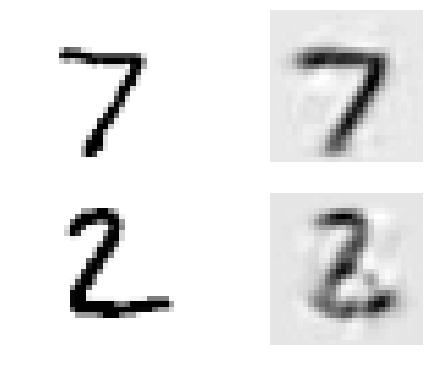

In [92]:
show_reconstructed_digits(X, outputs, "./my_model_stacked_denoising_dropout.ckpt")

## Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is **sparsity**: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature (if you could speak only a few words per month, you would probably try to make them worth listening to).<br/>

In order to favor sparse models, we must first measure the actual sparsity of the coding layer at each training iteration. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. **The batch size must not be too small, or else the mean will not be accurate.**<br/>

Once we have the mean activation per neuron, we want to penalize the neurons that are too active by adding a sparsity loss to the cost function. For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1, it must be penalized to activate less. One approach could be simply adding the squared error (0.3 – 0.1)2 to the cost function, but in practice a better approach is to use the Kullback–Leibler divergence (briefly discussed in Chapter 4), which has much stronger gradients than the Mean Squared Error.
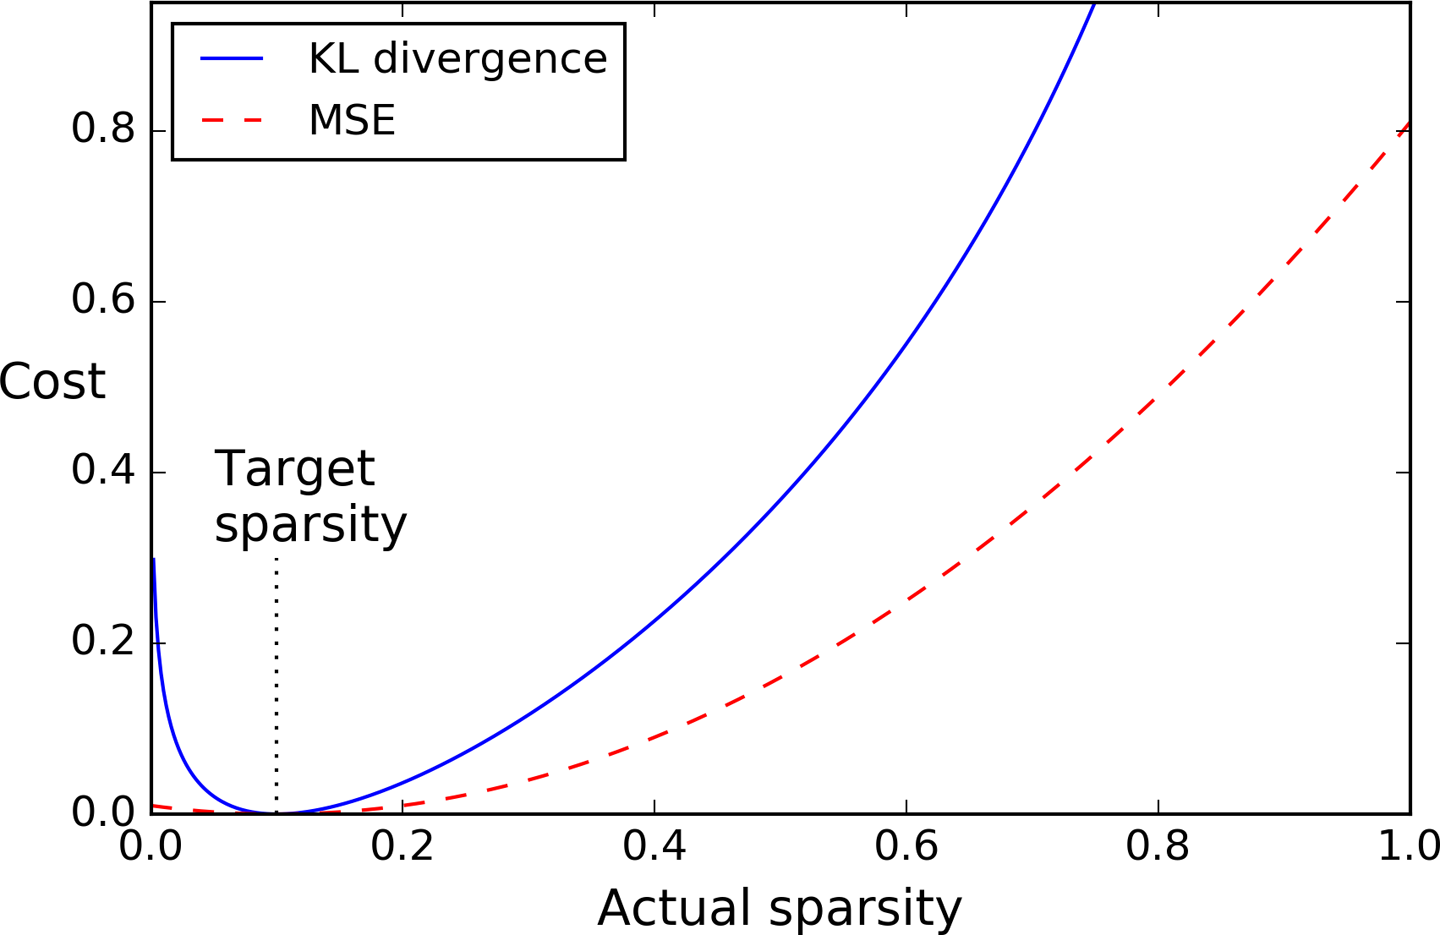

Given two discrete probability distributions P and Q, the KL divergence between these distributions, noted $D_{KL}(P ∥ Q)$, can be computed using following equation:
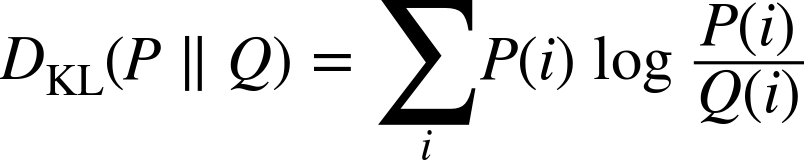

In our case, we want to measure the divergence between the target probability p that a neuron in the coding layer will activate, and the actual probability q (i.e., the mean activation over the training batch). So the KL divergence simplifies to following equation:

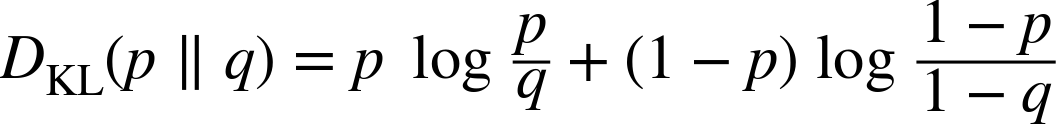

Saving figure sparsity_loss_plot


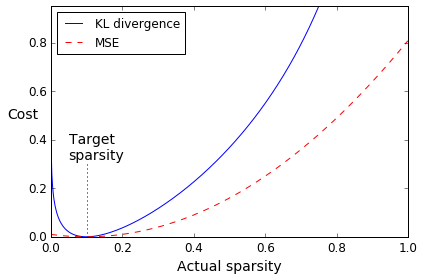

In [93]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mse, "r--", label="MSE")
plt.legend(loc="upper left")
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
save_fig("sparsity_loss_plot")

In [94]:
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 1000  # sparse codings
n_outputs = n_inputs

In [95]:
def kl_divergence(p, q):
    return p * tf.log(p / q) + (1 - p) * tf.log((1 - p) / (1 - q))

learning_rate = 0.01
sparsity_target = 0.1
sparsity_weight = 0.2

X = tf.placeholder(tf.float32, shape=[None, n_inputs])            # not shown in the book

An important detail is the fact that the activations of the coding layer must be between 0 and 1 (but not equal to 0 or 1), or else the KL divergence will return NaN (Not a Number). A simple solution is to use the logistic activation function for the coding layer:

`hidden1 = tf.nn.sigmoid(tf.matmul(X, weights1) + biases1)`

One simple trick can speed up convergence: instead of using the MSE, we can choose a reconstruction loss that will have larger gradients. Cross entropy is often a good choice. To use it, we must normalize the inputs to make them take on values from 0 to 1, and use the logistic activation function in the output layer so the outputs also take on values from 0 to 1. TensorFlow’s `sigmoid_cross_entropy_with_logits()` function takes care of efficiently applying the logistic (sigmoid) activation function to the outputs and computing the cross entropy.

In [97]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid) # not shown
outputs = tf.layers.dense(hidden1, n_outputs)                     # not shown

hidden1_mean = tf.reduce_mean(hidden1, axis=0) # batch mean
sparsity_loss = tf.reduce_sum(kl_divergence(sparsity_target, hidden1_mean))
reconstruction_loss = tf.reduce_mean(tf.square(outputs - X)) # MSE
loss = reconstruction_loss + sparsity_weight * sparsity_loss

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

In [98]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [99]:
n_epochs = 100
batch_size = 1000

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        reconstruction_loss_val, sparsity_loss_val, loss_val = sess.run([reconstruction_loss, sparsity_loss, loss], feed_dict={X: X_batch})
        print("\r{}".format(epoch), "Train MSE:", reconstruction_loss_val, "\tSparsity loss:", sparsity_loss_val, "\tTotal loss:", loss_val)
        saver.save(sess, "./my_model_sparse.ckpt")

08% Train MSE: 0.125994 	Sparsity loss: 0.315763 	Total loss: 0.189147
1 Train MSE: 0.0593644 	Sparsity loss: 0.0130131 	Total loss: 0.061967
2 Train MSE: 0.0512018 	Sparsity loss: 0.275896 	Total loss: 0.106381
3 Train MSE: 0.049854 	Sparsity loss: 0.241798 	Total loss: 0.0982135
4 Train MSE: 0.0449595 	Sparsity loss: 0.0276056 	Total loss: 0.0504806
58% Train MSE: 0.0400176 	Sparsity loss: 0.29192 	Total loss: 0.0984017
6 Train MSE: 0.0389145 	Sparsity loss: 0.020406 	Total loss: 0.0429957
78% Train MSE: 0.0370314 	Sparsity loss: 0.0829851 	Total loss: 0.0536284
8 Train MSE: 0.0342233 	Sparsity loss: 0.116166 	Total loss: 0.0574564
9 Train MSE: 0.0314701 	Sparsity loss: 0.239512 	Total loss: 0.0793725
10 Train MSE: 0.0277337 	Sparsity loss: 0.0256615 	Total loss: 0.032866
11 Train MSE: 0.0256569 	Sparsity loss: 0.0391676 	Total loss: 0.0334904
12 Train MSE: 0.0239584 	Sparsity loss: 0.033906 	Total loss: 0.0307396
13 Train MSE: 0.0231734 	Sparsity loss: 0.115704 	Total loss: 0.046314

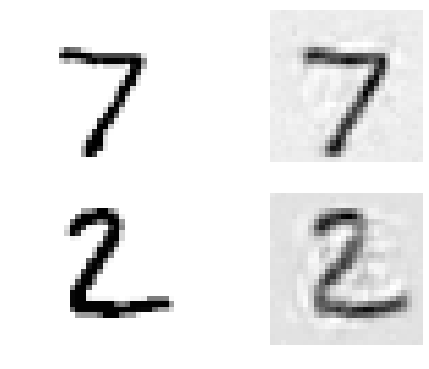

In [100]:
show_reconstructed_digits(X, outputs, "./my_model_sparse.ckpt")

Note that the coding layer must output values from 0 and 1 since we are using KL Divergence, which is why we use the sigmoid activation function

In [102]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.sigmoid)

To speed up training, you can normalize the inputs between 0 and 1, and use the corss entropy instead of the MSE for the cost function:

In [103]:
logits = tf.layers.dense(hidden1, n_outputs)
outputs = tf.nn.sigmoid(logits)

xentropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=X, logits=logits)
reconstruction_loss = tf.reduce_mean(xentropy)